In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [5]:
df = pd.read_excel('Adidas US Sales Datasets.xlsx')
df.head()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.0,0.50,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.0,0.30,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Women's Street Footwear,40.0,1000,400000.0,140000.0,0.35,In-store
3,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Women's Athletic Footwear,45.0,850,382500.0,133875.0,0.35,In-store
4,Foot Locker,1185732,2020-01-05,Northeast,New York,New York,Men's Apparel,60.0,900,540000.0,162000.0,0.30,In-store


We will analyze sales data, try to figure out trends and, based on this, make recommendations for further business.

### 1. EDA

In [8]:
df.shape

(9648, 13)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Retailer          9648 non-null   object        
 1   Retailer ID       9648 non-null   int64         
 2   Invoice Date      9648 non-null   datetime64[ns]
 3   Region            9648 non-null   object        
 4   State             9648 non-null   object        
 5   City              9648 non-null   object        
 6   Product           9648 non-null   object        
 7   Price per Unit    9648 non-null   float64       
 8   Units Sold        9648 non-null   int64         
 9   Total Sales       9648 non-null   float64       
 10  Operating Profit  9648 non-null   float64       
 11  Operating Margin  9648 non-null   float64       
 12  Sales Method      9648 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 980.0+ KB


In [10]:
df.isnull().sum()

Retailer            0
Retailer ID         0
Invoice Date        0
Region              0
State               0
City                0
Product             0
Price per Unit      0
Units Sold          0
Total Sales         0
Operating Profit    0
Operating Margin    0
Sales Method        0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [14]:
df.tail()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
9643,Foot Locker,1185732,2021-01-24,Northeast,New Hampshire,Manchester,Men's Apparel,50.0,64,3200.0,896.00,0.28,Outlet
9644,Foot Locker,1185732,2021-01-24,Northeast,New Hampshire,Manchester,Women's Apparel,41.0,105,4305.0,1377.60,0.32,Outlet
9645,Foot Locker,1185732,2021-02-22,Northeast,New Hampshire,Manchester,Men's Street Footwear,41.0,184,7544.0,2791.28,0.37,Outlet
9646,Foot Locker,1185732,2021-02-22,Northeast,New Hampshire,Manchester,Men's Athletic Footwear,42.0,70,2940.0,1234.80,0.42,Outlet
9647,Foot Locker,1185732,2021-02-22,Northeast,New Hampshire,Manchester,Women's Street Footwear,29.0,83,2407.0,649.89,0.27,Outlet


In [30]:
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
df['Units Sold'] = df['Units Sold'].astype(float)

### 2. Analysis of sales perfomance

In [31]:
# revenue
df['Total Sales'].sum()

899902125.0

In [36]:
# total sales by Product type
df.groupby('Product').agg({'Total Sales': 'sum'}).sort_values(by='Total Sales', ascending=False)

,Total Sales
Product,
Men's Street Footwear,208826244.0
Women's Apparel,179038860.0
Men's Athletic Footwear,153673680.0
Women's Street Footwear,128002813.0
Men's Apparel,123728632.0
Women's Athletic Footwear,106631896.0


In [37]:
# unit sales by Product type
df.groupby('Product').agg({'Units Sold': 'sum'}).sort_values(by='Units Sold', ascending=False)

,Units Sold
Product,
Men's Street Footwear,593320.0
Men's Athletic Footwear,435526.0
Women's Apparel,433827.0
Women's Street Footwear,392269.0
Women's Athletic Footwear,317236.0
Men's Apparel,306683.0


 1st place - Men's Street Footwear in terms of revenue 208826244.0 and sales units 593320.0
 
 2nd place  - Women's Apparel in terms of revenue 179038860.0, or Men's Athletic Footwear in sales units 435526.0, but in terms of sales they are almost the same.

### 3. Analysis of city retailers sales

In [40]:
df['City'].unique()

array(['New York', 'Houston', 'San Francisco', 'Los Angeles', 'Chicago',
       'Dallas', 'Philadelphia', 'Las Vegas', 'Denver', 'Seattle',
       'Miami', 'Minneapolis', 'Billings', 'Knoxville', 'Omaha',
       'Birmingham', 'Portland', 'Anchorage', 'Honolulu', 'Orlando',
       'Albany', 'Cheyenne', 'Richmond', 'Detroit', 'St. Louis',
       'Salt Lake City', 'New Orleans', 'Boise', 'Phoenix', 'Albuquerque',
       'Atlanta', 'Charleston', 'Charlotte', 'Columbus', 'Louisville',
       'Jackson', 'Little Rock', 'Oklahoma City', 'Wichita',
       'Sioux Falls', 'Fargo', 'Des Moines', 'Milwaukee', 'Indianapolis',
       'Baltimore', 'Wilmington', 'Newark', 'Hartford', 'Providence',
       'Boston', 'Burlington', 'Manchester'], dtype=object)

In [41]:
df['City'].nunique()

52

In [87]:
# Best seller in each city
df_grouped = df.groupby(['City', 'Retailer'])['Units Sold'].sum().reset_index()
df_sorted = df_grouped.sort_values(by=['City', 'Units Sold'], ascending=[True, False])
df_best = df_sorted.groupby('City').head(1)
df_worst = df_sorted.groupby('City').tail(1)
df_best.index = df_worst.index
df_city_sales = df_best.copy()
df_city_sales['Retailer 2'] = df_worst['Retailer']
df_city_sales.rename(columns={'Units Sold':'Units Sold best'}, inplace=True)
df_city_sales['Units Sold worst'] = df_worst['Units Sold']
df_city_sales['Difference'] = df_city_sales['Units Sold best'] - df_city_sales['Units Sold worst']
df_city_sales.head()

,City,Retailer,Units Sold best,Retailer 2,Units Sold worst,Difference
0,Albany,West Gear,47133.0,Kohl's,10053.0,37080.0
3,Albuquerque,Kohl's,43752.0,Sports Direct,8881.0,34871.0
5,Anchorage,Amazon,26749.0,Foot Locker,4066.0,22683.0
6,Atlanta,Sports Direct,41414.0,Foot Locker,14977.0,26437.0
10,Baltimore,Foot Locker,9322.0,West Gear,5647.0,3675.0


From here can see who were the best and worst sellers in each city and their difference

### 4. Analysis of sales methods

In [88]:
df['Sales Method'].unique()

array(['In-store', 'Outlet', 'Online'], dtype=object)

In [91]:
# group by Sales Method, calculate Operation Profit Margin Ratio
sales = df.groupby('Sales Method').agg({'Total Sales': 'sum', 'Operating Profit': 'sum'})
sales['Operation Profit Margin Ratio'] = sales['Operating Profit'] / sales['Total Sales'] * 100
sales.head()

,Total Sales,Operating Profit,Operation Profit Margin Ratio
Sales Method,,,
In-store,356643750.0,1.275913e+08,35.775557
Online,247672882.0,9.655518e+07,38.984961
Outlet,295585493.0,1.079883e+08,36.533693


From here can see that In-store(356643750.0) has the largest number of sales, next Outlet and Online sales.

By Operation Profit Margin Ratio best - Online sales (38.984961 %), next Outlet and In-store.

### 5. Price Analysis.

In [97]:
# calculate price boundaries
sorted(df['Price per Unit'].unique())

[7.0,
 8.0,
 9.0,
 9.999999999999996,
 10.0,
 10.000000000000002,
 10.000000000000004,
 11.0,
 12.0,
 13.0,
 14.0,
 14.999999999999996,
 15.0,
 15.000000000000002,
 15.000000000000007,
 15.000000000000014,
 16.0,
 17.0,
 18.0,
 19.0,
 19.999999999999996,
 20.0,
 20.000000000000004,
 20.000000000000007,
 20.00000000000001,
 21.0,
 22.0,
 23.0,
 24.0,
 24.999999999999993,
 24.999999999999996,
 25.0,
 25.000000000000007,
 25.00000000000001,
 25.000000000000018,
 26.0,
 27.0,
 28.0,
 29.0,
 29.999999999999993,
 30.0,
 30.000000000000004,
 30.00000000000001,
 30.000000000000014,
 31.0,
 32.0,
 33.0,
 34.0,
 34.99999999999999,
 35.0,
 35.00000000000001,
 35.000000000000014,
 36.0,
 37.0,
 38.0,
 39.0,
 39.99999999999999,
 40.0,
 40.00000000000001,
 40.000000000000014,
 41.0,
 42.0,
 43.0,
 44.0,
 44.999999999999986,
 44.99999999999999,
 45.0,
 45.00000000000001,
 45.000000000000014,
 46.0,
 47.0,
 48.0,
 49.0,
 49.999999999999986,
 49.99999999999999,
 50.0,
 50.000000000000014,
 51.0,
 52.0,

In [102]:
# divide the price boundaries into 13 ranges, assign each price a corresponding range, group
bins = np.linspace(0, 120, 13)
df['Range Price'] = pd.cut(df['Price per Unit'], bins)
df.groupby('Range Price')['Total Sales'].sum().reset_index().sort_values(by='Total Sales', ascending=False)

,Range Price,Total Sales
4,"(40.0, 50.0]",220666307.0
5,"(50.0, 60.0]",210865002.0
6,"(60.0, 70.0]",190679285.0
3,"(30.0, 40.0]",134726187.0
7,"(70.0, 80.0]",52787579.0
8,"(80.0, 90.0]",33547420.0
2,"(20.0, 30.0]",29636023.0
9,"(90.0, 100.0]",14468685.0
1,"(10.0, 20.0]",6574478.0
11,"(110.0, 120.0]",3080000.0


For pricing strategies, inventory management, and marketing campaigns can say that products in the range (40.0, 50.0] sell best, products in the ranges (50.0, 60.0] and (60.0, 70.0] are slightly behind them - we can consider products very popular, it the “golden” mean and focus on them.

The worst-selling products are those in the upper and lower price ranges (10.0, 20.0] and (100, 110], (110, 120].

To find out more detailed reasons for this behavior of buyers, more detailed research will be required.

### 6. Analysis of the most profitable products

In [104]:
# group by city and product, calculate 'Operation Profit Margin Ratio'
grouped_df = df.groupby(['City', 'Product']).agg({'Operating Profit': 'sum', 'Total Sales': 'sum'}).reset_index()
grouped_df['Operation Profit Margin Ratio'] = grouped_df['Operating Profit'] / grouped_df['Total Sales'] * 100
grouped_df.sort_values(['City', 'Operation Profit Margin Ratio'], ascending=[True, False], inplace=True)
grouped_df.groupby('City').head(3)

,City,Product,Operating Profit,Total Sales,Operation Profit Margin Ratio
3,Albany,Women's Apparel,2343150.19,4779109.0,49.029018
2,Albany,Men's Street Footwear,2649927.25,5773987.0,45.894237
0,Albany,Men's Apparel,1354932.08,3873553.0,34.979051
7,Albuquerque,Men's Athletic Footwear,1535979.67,3803130.0,40.387251
8,Albuquerque,Men's Street Footwear,1393976.08,3892153.0,35.815038
...,...,...,...,...,...
302,Wichita,Men's Street Footwear,1019368.68,2883508.0,35.351686
300,Wichita,Men's Apparel,496340.46,1405053.0,35.325391
309,Wilmington,Women's Apparel,1016327.95,2520405.0,40.323994
310,Wilmington,Women's Athletic Footwear,500967.12,1242580.0,40.316689


Now can see which type of product is the most profitable in each city.
In Albany - Women's Apparel with Operating Margin Ratio 49%,
in Albuquerque - Men's Athletic Footwear 40.39 %, Wilmington - Women's Apparel 40.32 %.

Therefore, an increase in the sale of this products - profits will be distributed faster.

In [111]:
# group by city and product, calculate 'Total sales'
grouped_df = df.groupby(['Product', 'City']).agg({'Total Sales': 'sum'}).reset_index()
grouped_df.sort_values(['Product', 'Total Sales'], ascending=[True, False], inplace=True)
print(grouped_df.groupby('Product').head(1).reset_index(drop=True), '\n')
print(grouped_df.groupby('Product').tail(1).reset_index(drop=True))


                     Product           City  Total Sales
0              Men's Apparel       New York    6835166.0
1    Men's Athletic Footwear       New York    6301528.0
2      Men's Street Footwear     Charleston    9479502.0
3            Women's Apparel     Charleston    8147789.0
4  Women's Athletic Footwear       New York    5201048.0
5    Women's Street Footwear  San Francisco    5549840.0 

                     Product   City  Total Sales
0              Men's Apparel  Omaha     530197.0
1    Men's Athletic Footwear  Omaha     942983.0
2      Men's Street Footwear  Omaha    2131074.0
3            Women's Apparel  Omaha    1202661.0
4  Women's Athletic Footwear  Omaha     465677.0
5    Women's Street Footwear  Omaha     656446.0


Here can see which city is best to sell each type of product: New York, Charleston, San Francisco. This will allow you to choose where and how much to bring new goods first.

In contrast, Omaha was the worst performer in overall sales.

### 7. Analysis Operating Profit Margin Ratio by retailer in cities 

In [112]:
# Previously, we already assessed sellers in cities by their units sold, now by total sales
grouped_df = df.groupby(['City', 'Retailer']).agg({'Total Sales': 'sum', 'Operating Profit': 'sum'}).reset_index()
grouped_df['Operation Profit Margin Ratio'] = grouped_df['Operating Profit'] / grouped_df['Total Sales'] * 100
grouped_df.sort_values(by=['City', 'Total Sales', 'Operation Profit Margin Ratio'], ascending=[True, False, False])

,City,Retailer,Total Sales,Operating Profit,Operation Profit Margin Ratio
1,Albany,West Gear,20735165.0,8062399.80,38.882738
0,Albany,Kohl's,3692639.0,1367451.11,37.031811
2,Albuquerque,Kohl's,17065965.0,5783668.15,33.890074
3,Albuquerque,Sports Direct,2799051.0,954392.26,34.096994
4,Anchorage,Amazon,13365025.0,4143804.75,31.004841
...,...,...,...,...,...
103,St. Louis,West Gear,1701133.0,681457.25,40.059022
105,Wichita,Kohl's,6451914.0,2279774.62,35.334858
104,Wichita,Foot Locker,3520950.0,1230372.67,34.944338
106,Wilmington,Foot Locker,8387568.0,3077352.68,36.689451


**Observations**

Here shows the relationship between location, salesperson, total sales and Operation Profit Margin Ratio.
Can notice that:
 - in some cities sales are much better than others (Albany, Albuquerque),
 - in one city there is a significant difference in sales between sellers (Wichita Kohl's, Wichita Foot Locker),
 - not every seller has equally good sales in different cities (Albany Kohl's, Albuquerque Kohl's)
 - Operation Profit Margin Ratio does not always directly depend on the number of sales (Albuquerque Sports Direct, Anchorage Amazon)
 - different cities have different Operation Profit Margin Ratio (Albany, Anchorage).

**Summary**

The analysis provides information on the performance of stores in different cities and their performance.

Based on this data, steps can be taken to increase profits and profitability, expand stores, optimize products and introduce new products.


### 8. Time Series Analysis

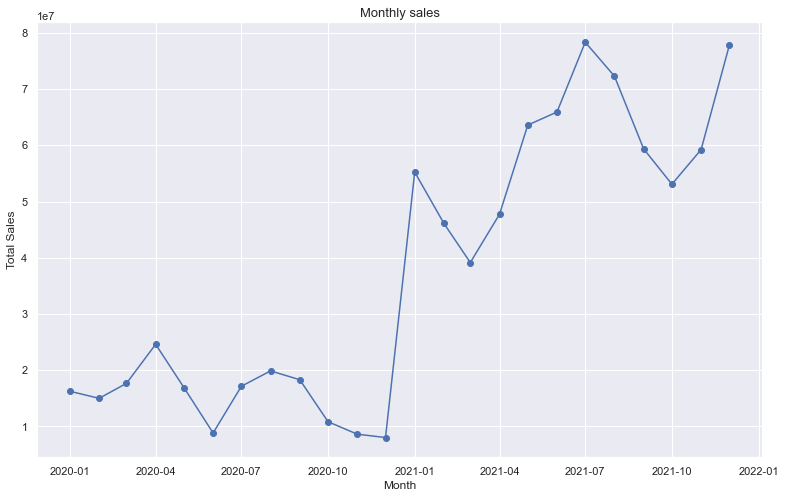

In [131]:
# group by month and calculate Total Sales
grouped_df = df.groupby(df['Invoice Date'].dt.to_period('M'))['Total Sales'].sum()
grouped_df.index = grouped_df.index.to_timestamp()

# plot
sns.set(style="darkgrid")
plt.figure(figsize=(13, 8))
plt.title('Monthly sales', fontsize=13)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.plot(grouped_df.index, grouped_df.values, marker='o')
plt.show()

**Observations**

From the graph can see an increase in sales in January and April and a decline in October, which indicates the seasonality of sales.

From this data you can take steps to increase profits, namely:
 - develop a strategy taking into account seasonality,
 - optimize product inventories,
 - optimize product delivery,
 - select favorable periods for introducing new products to the market.

### 9. Predictive Sales Analysis

c:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



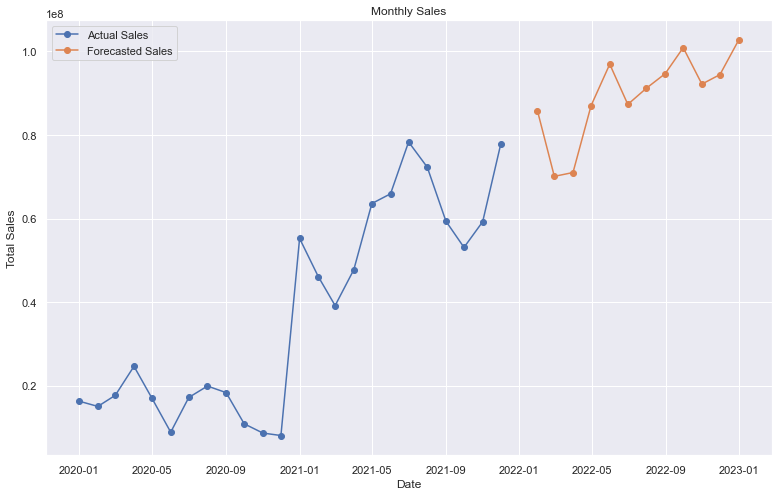

In [200]:
# use sarimax for 12 month prediction
sarimax = SARIMAX(grouped_df,order=(2,2,3), seasonal_order=(1, 1, 2, 4))
sarimax_fit = sarimax.fit()

# predictions
steps = 12
predict = sarimax_fit.forecast(steps=steps)

plt.figure(figsize=(13, 8))
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.title('Monthly Sales')
plt.plot(grouped_df.index, grouped_df.values, marker='o', label='Actual Sales')
plt.plot(pd.date_range(start=grouped_df.index[-1], periods=steps+1, freq='M')[1:], predict, marker='o', label='Forecasted Sales')

plt.legend()
plt.show()

**Finally**

The model makes plausible 12-month predictions given the available data. 
For more precise tuning and predictions, more information is needed (from 3 years).